In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from matplotlib import pyplot
from time import time
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras import*
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))
print(os.listdir("../input"))
print(os.listdir("../working"))
print(os.listdir("../input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/"))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['config', 'working', 'lib', 'input']
['quora-insincere-questions-classification', 'vector']
['submission.csv', '.ipynb_checkpoints', '__notebook_source__.ipynb']
['GoogleNews-vectors-negative300.bin']


In [2]:
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [3]:
print(train_df.columns)
print("not toxic:")
print(train_df[train_df.target==0]["question_text"].head())
print("toxic:")     
print(train_df[train_df.target==1]["question_text"].head())

Index(['qid', 'question_text', 'target'], dtype='object')
not toxic:
0    How did Quebec nationalists see their province...
1    Do you have an adopted dog, how would you enco...
2    Why does velocity affect time? Does velocity a...
3    How did Otto von Guericke used the Magdeburg h...
4    Can I convert montra helicon D to a mountain b...
Name: question_text, dtype: object
toxic:
22     Has the United States become the largest dicta...
30     Which babies are more sweeter to their parents...
110    If blacks support school choice and mandatory ...
114    I am gay boy and I love my cousin (boy). He is...
115                 Which races have the smallest penis?
Name: question_text, dtype: object


**Load Pre-Trained Word2Vec Model trained on news articles**

In [4]:
word2vec_model = word2vec.KeyedVectors.load_word2vec_format("../input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)

**Average Feature Vector( some cleaned text):
    Look through all words in the clean text
    add the vector of each words into a new Numpy Array
    divide by the number of words to get average
    the returned value is the word2vec representation of the clean text**

In [5]:
def avg_feature_vector(words):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((300,), dtype="float32")
    nwords = 0
    for word in words:
        try:
            nwords = nwords+1
            featureVec = np.add(featureVec, np.array(word2vec_model.wv[word]))
        except:
            pass
    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

****Clean Text, takes very long so I loaded into a pickle file**************

In [6]:
'''import nltk
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
stemmer = nltk.stem.SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
import re
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
import pickle
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    x = x.encode("ascii", errors="ignore").decode()
    x = x.lower().strip()
    x = x.replace('\r', ' ').replace('\n', ' ')
    x = re.sub(r'([\w\.-]+@[\w\.-]+)', 'email_se', x)
    x = re.sub(' +',' ',x)
    x = re.sub(r'[^\w\s]','',x)
    x = nltk.word_tokenize(x) 
    x = [lemmatizer.lemmatize(word, pos='v') for word in x if lemmatizer.lemmatize(word, pos='v') not in stop_words]
    x = [lemmatizer.lemmatize(word, pos='n') for word in x if lemmatizer.lemmatize(word, pos='n') not in stop_words]
    x = [stemmer.stem(word) for word in x]
    return x
def get_vector(text):
    text = preprocess(text)
    return avg_feature_vector(text)
train_df["question_text_vector"] = train_df["question_text"].apply(get_vector)
print(train_df["question_text_vector"])
train_df.to_pickle("training_set_with_vectors")'''

'import nltk\ndef warn(*args, **kwargs):\n    pass\nimport warnings\nwarnings.warn = warn\nstemmer = nltk.stem.SnowballStemmer(\'english\')\nfrom nltk.stem import WordNetLemmatizer\nimport re\nfrom string import punctuation\nfrom sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS\nstop_words = ENGLISH_STOP_WORDS\nimport numpy as np\nimport pandas as pd\nimport pickle\nlemmatizer = WordNetLemmatizer()\n\ndef preprocess(x):\n    x = x.encode("ascii", errors="ignore").decode()\n    x = x.lower().strip()\n    x = x.replace(\'\r\', \' \').replace(\'\n\', \' \')\n    x = re.sub(r\'([\\w\\.-]+@[\\w\\.-]+)\', \'email_se\', x)\n    x = re.sub(\' +\',\' \',x)\n    x = re.sub(r\'[^\\w\\s]\',\'\',x)\n    x = nltk.word_tokenize(x) \n    x = [lemmatizer.lemmatize(word, pos=\'v\') for word in x if lemmatizer.lemmatize(word, pos=\'v\') not in stop_words]\n    x = [lemmatizer.lemmatize(word, pos=\'n\') for word in x if lemmatizer.lemmatize(word, pos=\'n\') not in stop_words]\n    x = [stem

Read From pickle, input(word2vec representation) to X, output(labels(toxic,not toxic)) to Y 

In [7]:
train_df = pd.read_pickle("../input/vector/training_set_with_vectors")
print(len(train_df))
x = np.array(train_df.values)
X = []
for i in range(len(x)):
    b1 = x[i][3]
    X.append(b1)
Y = np.array(train_df['target'].values)
print(len(Y))

1306122
1306122


**One hot encoding for Y values**

**Split data into testing/training set**

In [8]:
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = np_utils.to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.08, random_state=42)

**Grid Search, Find the most optimal hyperparameters**

In [9]:
'''from sklearn.utils import class_weight
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import * 
from keras.layers import Activation, Dense

def create_model(layers,activation,optimizer):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(2, activation = 'sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
model = KerasRegressor(build_fn=create_model, verbose=0)
layers = [[200,100],[225,150,75],[220,160,100,50]]
activations = ['relu']
optimizers =['adadelta','adam','rmsprop']
param_grid = dict(layers=layers,activation=activations, optimizer= optimizers, batch_size=[1024],epochs=[20,40])
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train,y_train)'''

"from sklearn.utils import class_weight\nfrom keras.wrappers.scikit_learn import KerasRegressor\nfrom sklearn.model_selection import GridSearchCV\nfrom keras.optimizers import * \nfrom keras.layers import Activation, Dense\n\ndef create_model(layers,activation,optimizer):\n    model = Sequential()\n    for i, nodes in enumerate(layers):\n        if i == 0:\n            model.add(Dense(nodes, input_dim=X_train.shape[1]))\n            model.add(Activation(activation))\n        else:\n            model.add(Dense(nodes))\n            model.add(Activation(activation))\n    model.add(Dense(2, activation = 'sigmoid'))\n    # Compile model\n    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])\n    return model\nmodel = KerasRegressor(build_fn=create_model, verbose=0)\nlayers = [[200,100],[225,150,75],[220,160,100,50]]\nactivations = ['relu']\noptimizers =['adadelta','adam','rmsprop']\nparam_grid = dict(layers=layers,activation=activations, optimizer= optimiz

In [10]:
'''[grid_result.best_score_,grid_result.best_params_]'''

'[grid_result.best_score_,grid_result.best_params_]'

**Run the Model again with the most optimal hyperparameters found above**

In [11]:
model = Sequential()
input_dim = len(X_train[0])
print(input_dim)


model.add(Dense(input_dim, input_dim = input_dim , activation = 'relu'))
model.add(Dense(225, input_dim=X_train.shape[1]))
model.add(Dense(150, input_dim=X_train.shape[1]))
model.add(Dense(75, input_dim=X_train.shape[1]))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
history = model.fit(X_train, y_train,
        epochs=20,
        batch_size=1024,
        validation_split=0.2)
#class_weight=class_weights

print()
y_prediction = model.predict_classes(X_train)


300
Train on 961305 samples, validate on 240327 samples
Epoch 1/20
961305/961305 [==============================] - 25s 26us/step - loss: 0.1492 - acc: 0.9446 - val_loss: 0.1437 - val_acc: 0.9464
Epoch 2/20
961305/961305 [==============================] - 26s 27us/step - loss: 0.1375 - acc: 0.9483 - val_loss: 0.1419 - val_acc: 0.9468
Epoch 3/20
961305/961305 [==============================] - 25s 26us/step - loss: 0.1340 - acc: 0.9494 - val_loss: 0.1368 - val_acc: 0.9483
Epoch 4/20
961305/961305 [==============================] - 25s 26us/step - loss: 0.1319 - acc: 0.9501 - val_loss: 0.1359 - val_acc: 0.9488
Epoch 5/20
961305/961305 [==============================] - 24s 25us/step - loss: 0.1300 - acc: 0.9508 - val_loss: 0.1350 - val_acc: 0.9491
Epoch 6/20
961305/961305 [==============================] - 24s 24us/step - loss: 0.1280 - acc: 0.9512 - val_loss: 0.1408 - val_acc: 0.9466
Epoch 7/20
961305/961305 [==============================] - 25s 26us/step - loss: 0.1265 - acc: 0.9519 -

**Validation loss is constant while training loss decreased. **

**Not the best result but not bad and there is no overffiting and no need for early stop or dropout****

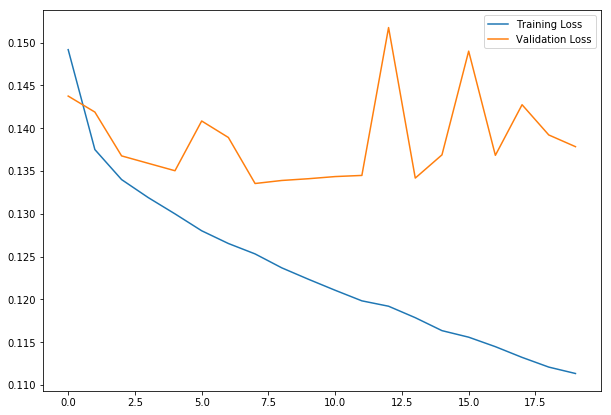

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

**Do the same preprocessing on testing sets**

In [13]:
import nltk
stemmer = nltk.stem.SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
import re
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
import pickle
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    x = x.encode("ascii", errors="ignore").decode()
    x = x.lower().strip()
    x = x.replace('\r', ' ').replace('\n', ' ')
    x = re.sub(r'([\w\.-]+@[\w\.-]+)', 'email_se', x)
    x = re.sub(' +',' ',x)
    x = re.sub(r'[^\w\s]','',x)
    x = nltk.word_tokenize(x) 
    x = [lemmatizer.lemmatize(word, pos='v') for word in x if lemmatizer.lemmatize(word, pos='v') not in stop_words]
    x = [lemmatizer.lemmatize(word, pos='n') for word in x if lemmatizer.lemmatize(word, pos='n') not in stop_words]
    x = [stemmer.stem(word) for word in x]
    return x
def get_vector(text):
    text = preprocess(text)
    return avg_feature_vector(text)
test_df["question_text_vector"] = test_df["question_text"].apply(get_vector)
print(test_df.head(1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


                    qid                        ...                                                       question_text_vector
0  0000163e3ea7c7a74cd7                        ...                          [0.08994675, 0.06884384, 0.019729614, 0.017761...

[1 rows x 3 columns]


Use my neural network model to predict for test data

In [14]:
test1 = np.array(test_df.values)

test2 = []
for i in range(len(test1)):
    b1 = test1[i][2]
    test2.append(b1)
print(np.array(test2).shape)
pred_list = model.predict_classes(np.array(test2))

(375806, 300)


**Lets take a look at the model's performance on the testing set. **

All the 1's look pretty toxic to me. Have to say the model is performing fairly well.
Don't know the exact accuracy since I missed the deadline for submission :(

In [15]:
pd.options.display.max_colwidth = 90
sub = pd.DataFrame(
    {'question': test_df["question_text"].tolist() ,
     'prediction': pred_list
    })
print("toxic stuff")
print("")
print("")
print(sub[sub.prediction==1].head(20))
print("")
print("non-toxic stuff")
print("")
print("")
print(sub[sub.prediction==0].head(20))


toxic stuff


                                                                                      question  prediction
0    Why do so many women become so rude and arrogant when they get just a little bit of we...           1
17                                                                      Can we eat human poop?           1
21   Why do so many people on this damn site not actually answer the question, but give som...           1
27   Let's say that hypothetically the alt-right nightmare comes true, and Muslims take ove...           1
58   Why do Bengali and Kolkata people dominate Hindi language speaking people from Delhi, ...           1
99   Shouldn’t we blame those who knew how bad Trump was and didn’t go to vote for today’s ...           1
105          Why does the media let Saudi Arabia get away with murder of 50,000 kids in Yemen?           1
211                            Why do Asian people hate white and black people? (READ COMMENT)           1
270              What d

In [ ]:
sub = pd.DataFrame(
    {'qid': test_df["qid"].tolist() ,
     'prediction': pred_list
    })
print(sub.columns)
print(sub.head(4))
print(sub[sub.prediction==1].head(3))
sub.to_csv("submission.csv",index=False)

Index(['qid', 'prediction'], dtype='object')
                    qid  prediction
0  0000163e3ea7c7a74cd7           1
1  00002bd4fb5d505b9161           0
2  00007756b4a147d2b0b3           0
3  000086e4b7e1c7146103           0
                     qid  prediction
0   0000163e3ea7c7a74cd7           1
17  00025f4a23df8d58e6ff           1
21  000383e4ebd22f6ede04           1
